## Creating a model

In this script, the code for preprocessing, processing, and all modeling is performed.

First the read from csv files, filtered and brought to a format readable by the ML function.

3 datasets are created, for 100, 500, and 1000 meter SAR resolution.


In [1]:
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from numpy import mean, std
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    silhouette_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    max_error,
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold, GridSearchCV, LearningCurveDisplay
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn import tree
from sklearn.impute import SimpleImputer
import pickle

workspace_directory = r'C:\Users\trygg\Documents\Master_project'  # HOME
# workspace_directory = r"C:\Users\tryggvisi\Documents\my-awesome-masters-project"  # WORK
# Change the current working directory to the specified workspace
os.chdir(workspace_directory)

In [43]:
def cleaning_the_data(file_old, file_era5, resolution, temperature, std):
    # Step 1: Read the main CSV datafile, either old and ERA5 data or just the old data
    path_to_folder = r"Data\Vindefjallen_data\Vindefjallen_cleaning\exploratory_data_analysis\2_values_from_raster_python_R"
    if file_era5 != 'none':
        path_old = os.path.join(path_to_folder, file_old)
        df_data1 = pd.read_csv(path_old)
        df_data1["original"] = 0  # 0 for old data

        path_era5 = os.path.join(path_to_folder, file_era5)
        df_data2 = pd.read_csv(path_era5)
        df_data2["original"] = 1  # 1 for ERA5 data
        df_data = pd.concat([df_data1, df_data2], ignore_index=True)
    elif file_era5 == 'none':
        path_old = os.path.join(path_to_folder, file_old)
        df_data = pd.read_csv(path_old)
        df_data["original"] = 0

    # Step 2: Rename columns in the main data frame
    df_data.rename(columns={"ID": "ID_clean", "OG_ID": "ID_preclean", "MiddleTime": "middleTime", "SnowDepth": "snow_depth",
                            "point_VH": "VH", "point_VV": "VV", "points_angle": "angle"}, inplace=True)

    # Step 3: Read the DEM dataset and prepare it for merging
    path_file = r"Data\Vindefjallen_data\Vindefjallen_cleaning\exploratory_data_analysis\4_DEM_data\DEM_extracted_values.csv"
    df_DEM = pd.read_csv(path_file)
    df_DEM = df_DEM.drop(["FID", "OG_ID", "Triangle", "Corner", "TriangleCo", "date", "SnowDepth", "SnowDepth_",
                          "temperatur", "x_4326", "y_4326", "x_3006", "y_3006", "MiddleTime"], axis=1)

    # Step 4: Read the ERA5 dataset
    # with 3 parameters and complete list.THIS IS OLD AND BAR ERA5
    path_data_era = r"Scripts\Python\ERA5\era5_temp\era5_vindefjallen_data_2023_3params_new.csv"
    df_read_era = pd.read_csv(path_data_era)

    # read the era5-land dataset
    # path_data_era_land = r"Scripts\Python\ERA5\era5_temp\era5_land_vindefjallen_data_2023_4params.csv" #með skt,sde,sd,rsn
    # með skt,sde,sd + vgt h og l og snow temp
    path_data_era_land = r"Scripts\Python\ERA5\era5_temp\era5_land_vindefjallen_data_2023_7params.csv"
    df_read_era_land = pd.read_csv(path_data_era_land)

    # Step 5b: Read vegetation type dataset and prepare it for merging
    read_vegtyp = r"Data\Landcover\Derived_datasets\points_with_vegtyp.xls"
    df_vegtyp = pd.read_excel(read_vegtyp)
    df_vegtyp = df_vegtyp.drop_duplicates(subset=['TriangleCo'])
    df_vegtyp.reset_index(drop=True, inplace=True)
    df_vegtyp = df_vegtyp[['TriangleCo', 'VEGETATION', 'VEGTYP']]

    # Step 6: Merge with DEM dataset
    df_merge_DEM = pd.merge(left=df_data, right=df_DEM, left_on=[
                            "ID_clean"], right_on=["ID"], how="left")

    # Step 7: Merge with ERA5 dataset
    df_merge_ERA5 = pd.merge(left=df_merge_DEM, right=df_read_era, left_on=[
                             "ID_clean"], right_on=["ID"], how="left")

    df = pd.merge(left=df_merge_ERA5, right=df_read_era_land, left_on=[
                  "ID_clean"], right_on=["ID"], how="left")

    # merge with df_vegtyp
    df = pd.merge(left=df, right=df_vegtyp, left_on=[
        "TriangleCorner"], right_on=["TriangleCo"], how="left")

    # Step 9: Convert snow depth to integer and remove rows with '+'
    df = df[~df["snow_depth"].str.contains(r"\d+\+")]
    df["snow_depth"] = df["snow_depth"].astype(np.int64)

    # Step 10: Remove rows with NaN in VH column and one outlier row
    df = df.dropna(subset=["VH"])

    # step 10.1: AC-28C because it's on a lake.
    df = df[df["TriangleCorner"] != "AC-28C"]

    # Step 11: Remove rows with geometric distortions
    df = df[df["points_mask"] == 0]

    # Step 13: Calculate VH/VV ratio
    df["VH/VV"] = df["VH"] / df["VV"]

    # Step 14: Filter data based on standard deviations
    # df = df[np.abs(df["VH/VV"] - df["VH/VV"].mean()) <= (std * df["VH/VV"].std())]
    df = df[np.abs(df["VH"] - df["VH"].mean()) <= (std * df["VH"].std())]
    df = df[np.abs(df["VV"] - df["VV"].mean()) <= (std * df["VV"].std())]

    # Step 15: One-hot encode orbitProp
    df[["orbitProp_ASCENDING", "orbitProp_DESCENDING"]
       ] = df["orbitProp"].str.get_dummies()

    # Step 16: Impute missing values in the temperature column
    if temperature == "drop":
        df = df.dropna(subset=["temperature"])
        print("Dropping rows with missing values in temperature")
    elif temperature in ["most_frequent", "mean"]:
        imp = SimpleImputer(strategy=temperature)
        df["temperature"] = imp.fit_transform(df[["temperature"]])
        print(
            f"Imputing missing values in temperature with {temperature} value")
    elif temperature == "skip":
        print("Skipping temperature imputation")
    else:
        print("No valid input for temperature imputation")

    # Step 17: Select columns to keep
    df = df[["ID_clean", "TriangleCorner", "date", "snow_depth", "time_difference",
            #  "temperature", "middleTime", "orbitProp_DESCENDING","orbitProp",
             "VH", "VV", "VH/VV", "angle", "TPI_100",  "TRI_100", "ASP_100", "SLOP_100", "ELEV_100",
             "TRI_500",  "ELEV_500",  "ASP_500", "SLO_500", "ASP_1000", "SLO_1000", "TRI_1000", "ELEV_1000", "TPI_500", "TPI_1000",
             'VEGETATION', 'VEGTYP',
             "orbitProp_ASCENDING",
             "original",
             "t2m", "rsn", "sd",
             "era5_l_rsn",  "era5_l_sd", "era5_l_skt", "era5_l_sde",
             "era5_l_lai_hv", "era5_l_lai_lv", "era5_l_tsn",
             ]]

    # Step 18: Reset index
    df.reset_index(drop=True, inplace=True)

    # Step 19: Convert time_difference to integer hours and round to nearest hour
    for i in range(len(df)):
        time_components = df.loc[i, "time_difference"].split(":")
        if len(time_components) == 3:
            hours, minutes, seconds = map(int, time_components)
        elif len(time_components) == 2:
            hours, minutes = map(int, time_components)
            seconds = 0
        else:
            raise ValueError("Invalid time string format")
        total_hours = round(hours + minutes / 60 + seconds / 3600)
        df.loc[i, "time_difference_rnd"] = total_hours

    df["snow_depth"] = df["snow_depth"].apply(lambda x: round(x, -1))

    df = df[np.abs(df["TRI_100"] - df["TRI_100"].mean())
            <= (4 * df["TRI_100"].std())]
    # converting snow depth to real snow depth

    df['resolution'] = resolution
    df['era5_l_sde'] = df['era5_l_sde'] * 100

    # filter snow depths over 50 and less than 300
    # df = df[(df['snow_depth'] < 110)]
    df = df[(df['snow_depth'] > 90)]
    df.reset_index(drop=True, inplace=True)

    return df

In [44]:
data_100 = r"values_to_points_R_100.csv"
data_500 = r"values_to_points_R_500.csv"
data_1000 = r"values_to_points_R_1000.csv"
data_era5_100 = r"values_to_points_R_era5_100.csv"
data_era5_500 = r"values_to_points_R_era5_500.csv"
data_era5_1000 = r"values_to_points_R_era5_1000.csv"

temperature = "skip" # "drop", "mean", "most_frequent", "skip". This is for temperature measurements from the in situ data. It was not used in the final model. 
std = 3 # Standard deviation for filtering out outliers.
df_100 = cleaning_the_data(data_100, data_era5_100,
                           '100', temperature=temperature, std=std)
print(df_100.shape)
df_500 = cleaning_the_data(data_500, data_era5_500,
                           '500', temperature=temperature, std=std)
print(df_500.shape)
df_1000 = cleaning_the_data(
    data_1000, data_era5_1000, '1000', temperature=temperature, std=std)
print(df_1000.shape)

Skipping temperature imputation
(211, 40)
Skipping temperature imputation
(214, 40)
Skipping temperature imputation
(215, 40)


In [42]:
df_1000['snow_depth'].describe()

count    299.000000
mean      67.826087
std       23.076104
min       10.000000
25%       50.000000
50%       80.000000
75%       80.000000
max      100.000000
Name: snow_depth, dtype: float64

# XBoost experimentation


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Dataset preparation function


def dataset_prep(df, model_group):
    features_SAR = [
        'era5_l_sde',
        "VH",
        "VV",
        "VH/VV",
        "angle",
        "time_difference_rnd",
        'orbitProp_ASCENDING',
    ]

    features_SAR_terr = [
        'era5_l_sde',
        "VH",
        "VV",
        "VH/VV",
        "angle",
        "time_difference_rnd",
        'orbitProp_ASCENDING',
        'TRI_1000', 'ELEV_1000', 'ASP_1000', 'SLO_1000', 'TPI_1000',
    ]

    features_sar_terr_era = [
        'era5_l_sde',
        "VH",
        "VV",
        "VH/VV",
        "angle",
        "time_difference_rnd",
        'orbitProp_ASCENDING',
        'TRI_1000', 'ELEV_1000', 'ASP_1000', 'SLO_1000', 'TPI_1000',
        "era5_l_skt",
        "era5_l_rsn",
        "era5_l_sd",
    ]

    if model_group == 'SAR':
        X = df[features_SAR]
        y = df['snow_depth']
        print('df prep ', X.shape)

    elif model_group == 'terrain':
        X = df[features_SAR_terr]
        y = df['snow_depth']
        print('df prep ', X.shape)

    elif model_group == 'era5_land':
        X = df[features_sar_terr_era]
        y = df['snow_depth']
        print('df prep ', X.shape)

    return X, y


# Example of loading your data
df = df_1000

# Prepare the dataset
# You can change 'SAR' to 'terrain' or 'era5_land' as needed
X, y = dataset_prep(df, 'era5_land')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, X_train_rsd, X_test_rsd = split_data(
    X, y, random_state=42)

# Define the Gradient Boosting model
model = XGBRegressor()

# Hyperparameters for tuning
params = {'max_depth': [3, 5, 6, 10, 15, 20],
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100, 300, 500, 800, 1000]}

v_outer = KFold(n_splits=5, shuffle=True, random_state=42)
# Grid search with cross-validation
grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=v_outer,
                                 scoring='neg_mean_squared_error', n_iter=60, verbose=1, random_state=42)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters found: {grid_search.best_params_}")

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", (-grid_search.best_score_)**(1/2.0))

In [ ]:
# Best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Example usage:
# Uncomment the following lines and replace 'your_dataset.csv' with your actual dataset path.
# df = pd.read_csv('your_dataset.csv')
# X, y = dataset_prep(df, 'SAR')  # Choose 'SAR', 'terrain', or 'era5_land'
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# grid_search.fit(X_train, y_train)
# y_pred = grid_search.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")

# processing


In [38]:
# Dataset prep. Preparing the dataset for modeling and creating X and y variables.
# era5_l_sde is not used for modeling. This is a workaround so it can be used later to compare with the predictions and it matches
# with the index of the input data.
def dataset_prep(df, model_group):
    features_SAR = [
        'era5_l_sde',

        "VH",
        "VV",
        "VH/VV",
        "angle",
        "time_difference_rnd",
        'orbitProp_ASCENDING',
    ]
    features_SAR_terr = [
        'era5_l_sde',

        "VH",
        "VV",
        "VH/VV",
        "angle",
        "time_difference_rnd",
        'orbitProp_ASCENDING',
        # "ELEV_100","ASP_100","SLOP_100","TPI_100","TRI_100",
        # 'TRI_500', 'ELEV_500', 'ASP_500', 'SLO_500', 'TPI_500',
        'TRI_1000', 'ELEV_1000', 'ASP_1000', 'SLO_1000', 'TPI_1000',
    ]
    features_sar_terr_era = [
        'era5_l_sde',
        "VH",
        "VV",
        "VH/VV",
        "angle",
        "time_difference_rnd",
        'orbitProp_ASCENDING',

        # "ELEV_100","ASP_100","SLOP_100", "TPI_100","TRI_100",
        # 'TRI_500', 'ELEV_500', 'ASP_500', 'SLO_500', 'TPI_500',
        'TRI_1000', 'ELEV_1000', 'ASP_1000', 'SLO_1000', 'TPI_1000',
        "era5_l_skt",
        "era5_l_rsn",
        "era5_l_sd",
    ]
    if model_group == 'SAR':
        X = df[features_SAR]
        y = df['snow_depth']
        print('df prep ', X.shape)

    if model_group == 'terrain':
        X = df[features_SAR_terr]
        y = df['snow_depth']
        print('df prep ', X.shape)

    if model_group == 'era5_land':
        X = df[features_sar_terr_era]
        y = df['snow_depth']
        print('df prep ', X.shape)
    return X, y

In [16]:
# split the data into 75% training and 25% testing
def split_data(X, y, random_state):

    X_train_rsd, X_test_rsd, y_train, y_test = train_test_split(
        X, y,

        test_size=0.25,

        random_state=random_state,

        stratify=y  # stratify the target variable, ensures that the distribution of the target variable is the same in both training and testing sets

    )

    # drop rsn from X_test and X_train

    X_train = X_train_rsd.drop(columns=['era5_l_sde'])

    X_test = X_test_rsd.drop(columns=['era5_l_sde'])

    X = X.drop(columns=['era5_l_sde'])

    print('training ', X_train.shape, X_test.shape)

    return X_train, X_test, y_train, y_test, X_train_rsd, X_test_rsd

In [ ]:
# https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d
# Searching for optimal hyperparameters using GridSearchCV
# See section 2.7.2 in thesis
# This can take a while to run, nr of hyperparameters x search k-folds x cv k-folds

def run_hyperparameter_modelling(X_train, y_train, random_state):
    """
    Run the modelling process using the given training data.

    Parameters:
    - X_train: The input features for training.
    - y_train: The target variable for training.
    - random_state: The random seed for reproducibility.

    Returns:
    - scores: A dictionary containing the evaluation scores for the model.
    """
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=random_state)
    # define the model

    model = RandomForestRegressor(random_state=random_state)
   # define grid of hyperparameters to search
    grid = {
        "n_estimators": [int(x) for x in np.linspace(start=100, stop=400, num=4)],
        "max_depth": [int(x) for x in np.linspace(10, 50, num=5)],
        'max_features': [0.3, 0.4, 0.5],
    }
    # define search. A 5-fold Grid search that iterates over the grid of hyperparameters
    search = GridSearchCV(
        model, grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=cv_inner
    )

    # execute the nested cross-validation
    scores = cross_validate(
        search,
        model,
        X_train,
        y_train,
        scoring=('r2',
                 'neg_mean_squared_error',
                 'neg_mean_absolute_error',
                 'neg_root_mean_squared_error'),
        cv=cv_outer,
        n_jobs=-1,
        return_estimator=True,
    )
    return scores

In [17]:
# https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d
# Run the modelling process using the hyperparameters from previously.
def run_modelling(X_train, y_train, random_state):
    """
    Run the modelling process using the given training data.

    Parameters:
    - X_train: The input features for training.
    - y_train: The target variable for training.
    - random_state: The random seed for reproducibility.

    Returns:
    - scores: A dictionary containing the evaluation scores for the model.
    """
    cv_outer = KFold(n_splits=10, shuffle=True,
                     random_state=random_state)  # 10-fold cross-validation
    # define hyperparameters
    params = {
        'n_estimators': 100,
        'max_depth': 8,
        'max_features': 0.3,
    }
    model = RandomForestRegressor(random_state=random_state, **params)
    # execute the nested cross-validation
    scores = cross_validate(
        model,
        X_train,
        y_train,
        scoring=('r2',
                 'neg_mean_squared_error',
                 'neg_mean_absolute_error',
                 'neg_root_mean_squared_error'),
        cv=cv_outer,
        n_jobs=-1,
        return_estimator=True,
    )
    return scores

In [8]:
# testing of XGboost
# https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d
def run_modelling(X_train, y_train, random_state):
    # configure the cross-validation procedure
    # cv_inner = KFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=random_state)
    # define the model
    params = {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 6,
              'learning_rate': 0.01, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5}
    model = XGBRegressor(random_state=random_state, **params)

# new setup with just parameters

    # execute the nested cross-validation
    scores = cross_validate(
        # search,
        model,
        X_train,
        y_train,
        scoring=('r2',
                 'neg_mean_squared_error',
                 'neg_mean_absolute_error',
                 'neg_root_mean_squared_error'),
        cv=cv_outer,
        n_jobs=-1,
        return_estimator=True,
    )
    print("XGB")
    return scores

In [13]:
# A logging function to save the results of the modelling process
def logging_to_dict(
    scores, X_train, X_test, y_train, y_test, X_test_rsd, comment, random_state
):
    from numpy import std
    from numpy import mean

    def mean_error(y_test, y_pred):
        return (y_pred - y_test).sum() / len(y_pred)

    # model evaluation
    mae_mean = mean(-scores["test_neg_mean_absolute_error"])
    mae_std = std(scores["test_neg_mean_absolute_error"])
    mse_mean = mean(-scores["test_neg_mean_squared_error"])
    mse_std = std(scores["test_neg_mean_squared_error"])
    rmse_mean = mean(-scores["test_neg_root_mean_squared_error"])
    rmse_std = std(scores["test_neg_root_mean_squared_error"])
    r2_mean = mean(scores["test_r2"])
    r2_std = std(scores["test_r2"])

    # best model setup
    bestRMSE = np.argmax(scores["test_neg_mean_squared_error"])
    rfr_fit = scores["estimator"]

    try:

        best_rfr = rfr_fit[bestRMSE].best_estimator_
    except:
        best_rfr = rfr_fit[bestRMSE]
        best_rfr.fit(X_train, y_train)
        y_pred = best_rfr.predict(X_test)

    try:
        best_best_params = rfr_fit[bestRMSE].best_params_
    except:
        best_best_params = "none"

    # test data evaluatin/best model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = best_rfr.score(X_test, y_test)
    me = mean_error(y_test, y_pred)

    # feature imporance
    columns = list(X_train.columns)
    feature_imp = list(best_rfr.feature_importances_)

    # convert from np to list
    listi_y_pred = list(y_pred)
    listi_y_test = list(y_test)
    listi_era5_rsd = list(X_test_rsd["era5_l_sde"])
    results = {
        "mae_mean": mae_mean,
        # "mae_std": mae_std,
        "mse_mean": mse_mean,
        # "mse_std": mse_std,
        "rmse_mean": rmse_mean,
        # "rmse_std": rmse_std,
        "r2_mean": r2_mean,
        # "r2_std": r2_std,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "me": me,
        "columns": columns,
        "feature_imp": feature_imp,
        "best_params": best_best_params,
        "comment": comment,
        "y_prediction": listi_y_pred,
        "y_test": listi_y_test,
        "rsd_at_y_pred": listi_era5_rsd,
        "random_state": random_state,
        "best_rfr": best_rfr,
    }
    return results

In [ ]:
# loop through the datasets and model groups. Run the modelling process and save the results to a dictionary
list_datasets = [
    df_100,
    df_500,
    df_1000
]
list_of_features = [
    'SAR',
    'terrain',
    'era5_land'
]
random_state = 210
final_results_dict = {}
for dataset in list_datasets:

    for model_group in list_of_features:

        comment = dataset['resolution'][0] + '' + model_group
        print(comment)
        X, y = dataset_prep(dataset, model_group)  # prepare the dataset
        X_train, X_test, y_train, y_test, X_train_rsd, X_test_rsd = split_data(
            X, y, random_state)  # split the data
        # run the modelling process
        scores = run_modelling(X_train, y_train, random_state)
        final_results_dict[comment] = logging_to_dict(
            scores, X_train, X_test, y_train, y_test, X_test_rsd, comment, random_state)  # save the results to a dictionary

## Run multiple times


In [21]:
# Same are the previous cell, but as a function that makes it possible to run the algorithm with different random states,
# which splits the data differently and gives different results
def run_algorithm(random_state):
    list_datasets = [
        df_100,
        df_500,
        df_1000
    ]
    list_of_features = [
        'SAR',
        'terrain',
        'era5_land'
    ]

    final_results_dict = {}
    for dataset in list_datasets:
        # print(dataset)
        for model_group in list_of_features:
            comment = dataset['resolution'][0] + '' + model_group
            print(comment)
            X, y = dataset_prep(dataset, model_group)
            X_train, X_test, y_train, y_test, X_train_rsd, X_test_rsd = split_data(
                X, y, random_state)
            scores = run_modelling(X_train, y_train, random_state)
            final_results_dict[comment] = logging_to_dict(
                scores, X_train, X_test, y_train, y_test, X_test_rsd, comment, random_state)
    return final_results_dict

In [39]:
#run the algorithm with different random states, and save the results to a dictionary
multiple_results = {}
for i in range(10):
    random_state = 42*i
    print(random_state)
    final_results_dict = run_algorithm(random_state)
    print(final_results_dict)
    multiple_results[i] = final_results_dict

0
100SAR
df prep  (293, 7)
training  (219, 6) (74, 6)
100terrain
df prep  (293, 12)
training  (219, 11) (74, 11)
100era5_land
df prep  (293, 15)
training  (219, 14) (74, 14)
500SAR
df prep  (293, 7)
training  (219, 6) (74, 6)
500terrain
df prep  (293, 12)
training  (219, 11) (74, 11)
500era5_land
df prep  (293, 15)
training  (219, 14) (74, 14)
1000SAR
df prep  (299, 7)
training  (224, 6) (75, 6)
1000terrain
df prep  (299, 12)
training  (224, 11) (75, 11)
1000era5_land
df prep  (299, 15)
training  (224, 14) (75, 14)
{'100SAR': {'mae_mean': 19.34653972601523, 'mse_mean': 539.056469971684, 'rmse_mean': 22.939594149591457, 'r2_mean': -0.2602316607035518, 'mae': 20.237984158930363, 'mse': 585.6256201060784, 'rmse': 24.19970289292987, 'r2': -0.06315007813979756, 'me': -0.1268382454524069, 'columns': ['VH', 'VV', 'VH/VV', 'angle', 'time_difference_rnd', 'orbitProp_ASCENDING'], 'feature_imp': [0.18563222194098108, 0.22004564536358606, 0.19305059525246243, 0.22073566556098437, 0.156113244719383

In [41]:
name_model = "modelling_results_10_depth8_less100cm.pkl"
pickleName = r"Scripts\Python\data_analysis\results_fermented_pickle"
path_to_pickle = os.path.join(pickleName, name_model)
try:
    # Store the results dictionary in a pickle file
    with open(path_to_pickle, 'xb') as handle:
        # pickle.dump(final_results_dict, handle)
        pickle.dump(multiple_results, handle)

    print('New pickle created')
except FileExistsError:
    print('FileExistsError')

FileExistsError


In [ ]:
with open(path_to_pickle, 'rb') as file:
    loaded_model = pickle.load(file)

loaded_model

## Learning curve plot


In [24]:
list_datasets = [df_100, df_500, df_1000]
list_of_features = [
    'SAR',
    'terrain',
    'era5_land'
]
X, y = dataset_prep(list_datasets[0], list_of_features[2])


X_train, X_test, y_train, y_test, X_train_rsd, X_test_rsd = split_data(
    X, y, 42)
X = X.drop(columns=['era5_l_sde'])

df prep  (211, 15)
training  (158, 14) (53, 14)


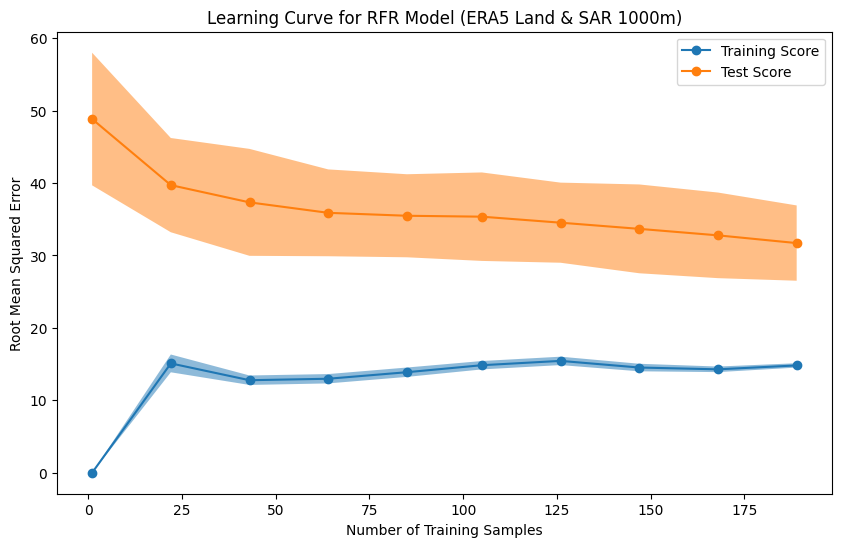

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Define the model
params = {
    'n_estimators': 100,
    'max_depth': 8,
    'max_features': 0.3
}
model = RandomForestRegressor(random_state=42, **params)

# Parameters for learning curve
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.01, 1.0, 10),
    "cv": KFold(n_splits=10, shuffle=True, random_state=42),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "scoring": "neg_root_mean_squared_error",
    # "scoring": "r2",
    "negate_score": True,
}

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the learning curve
LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)

# Customize the legend and title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for RFR Model (ERA5 Land & SAR 1000m)")
ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("Root Mean Squared Error")

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Define the model
params = {
    'n_estimators': 100,
    'max_depth': 8,
    'max_features': 0.3
}
model = RandomForestRegressor(random_state=42, **params)

# Parameters for learning curve
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.01, 1, 10),
    "cv": KFold(n_splits=10, shuffle=True, random_state=42),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "scoring": "neg_root_mean_squared_error",
    # "scoring": "r2",
    "negate_score": True,
}

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the learning curve
LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)

# Customize the legend and title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for RFR Model (ERA5 Land & SAR 1000m)")
ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("Root Mean Squared Error")

# Show the plot
plt.show()

# Make true prediction


In [ ]:
# import dataframe from file
# path_to_new_prediction = r"C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\data\values_from_points.xls"
# path_to_new_prediction = r"C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\data\values_from_points_2018.xls"
path_to_new_prediction = r"C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\data\values_from_points_20190315.xls"
df_prediction_original = pd.read_excel(path_to_new_prediction)
df_prediction = pd.read_excel(path_to_new_prediction)
df_prediction.columns

# add column orbitProp_ASCENDING and all = 1
df_prediction['orbitProp_ASCENDING'] = 1

df_prediction["time_difference_rnd"] = 1
df_prediction.drop(columns=[
    # 'FID',
    'pointid'
], inplace=True)
# ratio of VH/VV
df_prediction["VH/VV"] = df_prediction["VH"] / df_prediction["VV"]
df_prediction.drop(columns=['sde'], inplace=True)

In [ ]:

df_prediction.columns
# Change columns names from df_prediction to X_train clumn names
df_prediction.rename(columns={"VH": "VH",
                              "VV": "VV",
                              "VH/VV": "VH/VV",
                              "inc": "angle",
                              "time_difference_rnd": "time_difference_rnd",
                              'orbitProp_ASCENDING': 'orbitProp_ASCENDING',
                              # 'era5_l_sde': 'era5_l_sde',
                              'TRI': 'TRI_1000',
                              'elev': 'ELEV_1000',
                              'asp': 'ASP_1000',
                              'slo': 'SLO_1000',
                              'TPI': 'TPI_1000',
                              'skt': 'era5_l_skt',
                              'rsn': 'era5_l_rsn',
                              'sd': 'era5_l_sd'
                              }, inplace=True)

# arrange the order to match X_train
df_prediction = df_prediction[[
    'VH', 'VV', 'VH/VV', 'angle', 'time_difference_rnd', 'orbitProp_ASCENDING',
    #    'TRI_1000', 'ELEV_1000', 'ASP_1000', 'SLO_1000', 'TPI_1000',
    #    'era5_l_skt', 'era5_l_rsn', 'era5_l_sd'
]]
df_prediction.columns

In [ ]:
predictor = final_results_dict['1000SAR']['best_rfr']
prediction = predictor.predict(df_prediction)

In [ ]:
predictor = final_results_dict['1000era5_land']['best_rfr']
prediction = predictor.predict(df_prediction)

In [ ]:
len(prediction)

In [ ]:
df_prediction_original

# only keep the columns we need
df_prediction_original = df_prediction_original[[
    # 'FID',
    'pointid']]
# append prediction to df_prediction_original
df_prediction_original['SD_pred'] = prediction
df_prediction_original
# export to csv

df_prediction_original.to_csv(
    r"C:\Users\trygg\Documents\Master_project\Data\Prediction_SD\data\prediction_1000_SAR_20190315.csv")